## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Dependencies

In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from moviepy.editor import VideoFileClip

## Functions

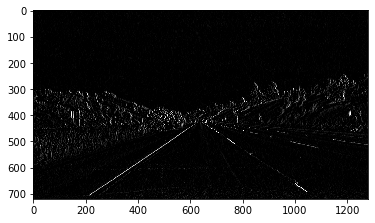

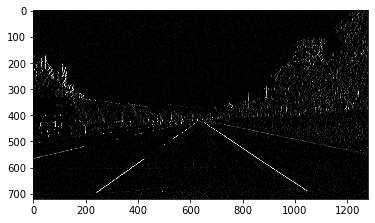

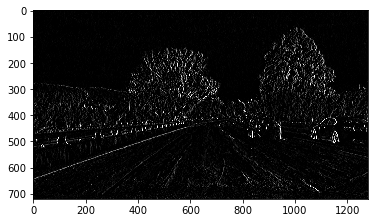

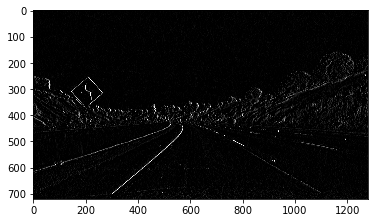

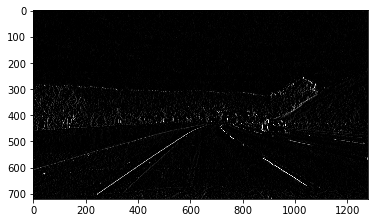

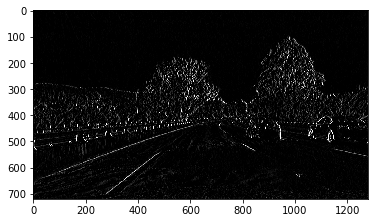

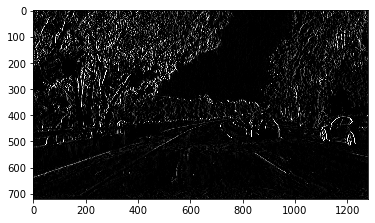

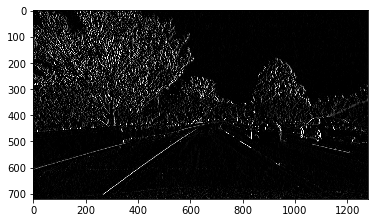

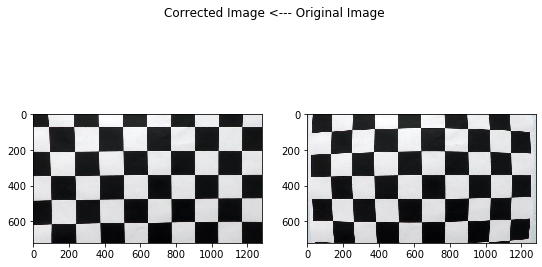

In [22]:
def show_img(img):
    """Simple helper function used to visualize output during development
    Takes an np.array image as input - returns nothing"""

    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow(img)
    plt.show()

def calibrateCam(rootpath="./camera_cal/", nx=9, ny=6):
    """calibrateCamera is called to perform calibration on a single camera once at the start of the script
    It acts on all files with a .jpg (case-sensitive) extension contained in rootpath. 
    All qualifying files are expected to have a minimum of nx and ny checkerboard intersections.
    nx and ny are the # of internal corners on checkerboard paper (not img)"""

    calImgPaths = [rootpath + i for i in os.listdir(rootpath) if i[-3:] == 'jpg']

    # For storage of image & object points (img points output of calibration calls)
    # objPts = np.meshgrid()
    imgPts = []
    objPts = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    lastImgSize = 0 # Used in error check for img.shape within loop

    # For each given image
    for path in calImgPaths:

        # Read as grayscale and find corners using fxn params
        img = cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE)
        ok, corners = cv2.findChessboardCorners(img, (nx, ny), None)

        # If corners are returned for a given image
        if ok == True:
            # Add list entry for located corners and unit matrix for each success
            imgPts.append(corners)
            objPts.append(objp)
        
        # Error checking to see if all of the calibration images are of similar resolution
        # Was originally a same-size check, but atleast one of the images is not the same size
        size = np.shape(img)
        if type(lastImgSize) is int:
            pass
        elif (lastImgSize[0] - size[0] > 50) | (lastImgSize[1] - size[1] > 50): 
            raise Exception("Calibration images must all be of similar resolution")
        
        lastImgSize = size
    
    ok, camMat, distortCoeff, rotVec, transVec = cv2.calibrateCamera(objPts, imgPts, size[::-1], None, None)

    return ok, camMat, distortCoeff

def imageUndistortRoutine(inputFilePath, outputFilePath, camMat, distMat):
    """Strictly used to satisfy deliverables for demonstrating image distortion correction
    Outputs a PDF comparing distorted & undistorted cal. file"""

    x = cv2.imread(inputFilePath)
    y = cv2.undistort(x, camMat, distMat, None, camMat)
    fig = plt.figure(figsize=(9,5))
    fig.add_subplot(121)
    plt.imshow(y)
    fig.add_subplot(122)
    plt.imshow(x)
    plt.suptitle("Corrected Image <--- Original Image ")

    plt.savefig(outputFilePath)

def doSobel(img, kernel=3, dx=1, dy=0, ddepth=-1):
    """Apply sobel in designated direction. Defaults to 1st order dx
    img: single-channel image to operate on
    theta: can range (-np.pi/2 thru np.pi/2))
    kernel: any odd integer >= 3
    returns: np.array of same shape as img, with sobel applied"""
    
    if kernel % 2 != 1:
        raise Exception("param 'kernel' must be an odd value")

    # Consider eventually adding error-check for single-channel image here

    img = cv2.Sobel(img, ddepth, dx, dy, ksize=kernel)

    return img

def makeImgProcHandler(camMat, distortMat):
    """makeImgProcHandler is a function closure that generates the function signature required by
    VideoFileClip.fl_image() method [single parameter for image @ time t]. Generated function
    performs all image processing for this assignment"""

    def ImgProcHandler(img):
        """See docstring for makeImgProcHandler - VideoFileClip.fl_image() method will supply RGB
        image from video file as a numpy array"""

        # Undistort image
        img = cv2.undistort(img, camMat, distortMat, None, camMat)
        
        # Apply logic to find lane lines
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # img to grayscale
        img = doSobel(img)
        
        return img

    return ImgProcHandler

def vidProcRoutine(inputVidPath, outputVidPath, imageProcFunc):
    """vidProcRoutine serves as a simple wrapper function that takes in inputVidPath,
    and writes an altered video to outputVidPath using imageProcFunc"""

    inputVid = VideoFileClip(inputVidPath, audio=False)
    alteredClip = inputVid.fl_image(imageProcFunc)
    alteredClip.write_videofile(outputVidPath)

    return alteredClip

def main():
    """Main routine for generating project deliverables"""

    # Calibrate the camera
    ok, camMat, distortMat = calibrateCam()
    
    # Generate image processing fxn compatible with moviepy's VideoClipFile object
    imgHandler = makeImgProcHandler(camMat, distortMat)

    # Process all test images in ./test_image directory per imgHandler pipeline and save to
    # ./test_images_output/{fname}
    path = "./test_images/"
    for test_file in os.listdir(path):
        img = mpimg.imread(path + test_file, format='jpg')
        img = imgHandler(img) # Consider implementing a decorator for saving files at the end of random functions
        plt.imshow(img, cmap='gray')
        plt.show()
        plt.imsave("./output_images/" + test_file, img, cmap='gray')

    # Fulfill distortion comparison deliverable
    imageUndistortRoutine("./camera_cal/calibration1.jpg", "./output_images/calibration1.pdf", camMat, distortMat)

    # Execute video processing on test videos of interest
    outputPath = "./test_videos_output/project_video_output.mp4"
    inputPath = "./project_video.mp4"

    alteredVid = vidProcRoutine(inputPath, outputPath, imgHandler)

    return img

img = main()

In [7]:
np.shape(img)

(720, 1280)

In [12]:
img.max()

757.0